# Example of detrending

In [1]:
push!(LOAD_PATH,"C:/JMB/divand.jl/src","."); using divand;cd("C:/JMB/divand.jl");cd("examples");using PyPlot

using NCDatasets
using DataStructures

# Load a more efficient version of sparse matrix multiplication
include(joinpath(Pkg.dir("divand"),"src","override_ssmult.jl"))

LoadError: [91mcould not open file C:\Users\jmbeckers\.julia\v0.6\divand\src\override_ssmult.jl[39m

## Bathmetry reading

In [2]:
bathname = "gebco_30sec_16.nc"

if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/o0vinoQutAC7eb0/download",bathname)
else
    info("Bathymetry file already downloaded")
end

bathisglobal = true;

INFO: Bathymetry file already downloaded


## Bathymetry and grid preparation

In [3]:
dx = dy = 0.125

lonr = 27:dx:42
latr = 40:dy:47
depthr = [0., 10, 20, 30, 50]#, 75, 100, 125, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1750, 2000];


mask,(pm,pn,po),(xi,yi,zi) = divand.divand_rectdom(lonr,latr,depthr)



bx,by,b = divand.load_bath(bathname,true,lonr,latr)



mask = falses(size(b,1),size(b,2),size(depthr,1))


    for j = 1:size(b,2)
        for i = 1:size(b,1)
        mask[i,j,:] = b[i,j] >=1.0
        end
    end



Look at topology

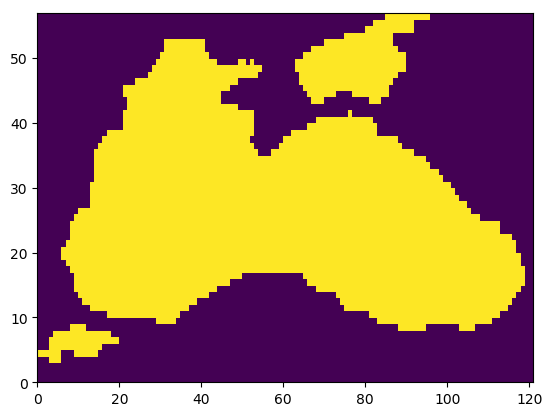

PyObject <matplotlib.collections.PolyCollection object at 0x00000000285DF470>

In [4]:
pcolor(mask[:,:,1]')

Take out Marmara and Azov sea

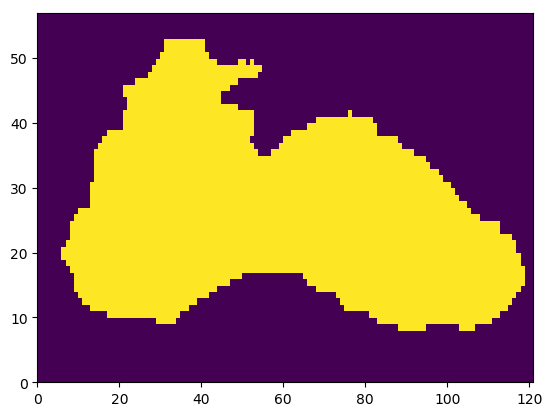

PyObject <matplotlib.collections.PolyCollection object at 0x00000000374AFCF8>

In [5]:
# mask Azov and Marmara sea

sel1= (xi.>34.75) .& (yi.>45.25)
mask[sel1]=false
sel1= (xi.<29.5) .& (yi.<41.125)
mask[sel1]=false


pcolor(mask[:,:,1]')

Load data

In [6]:
value,lon,lat,depth,timeval,ids = divand.loadbigfile("Salinity.bigfile")
@show size(value)

x = "1929-11T11:52"
x = "1929-11T11:52"
size(value) = (4820520,)


(4820520,)

Select data (taking out Marmara and Azov sea)

size(value) = (4820520,)


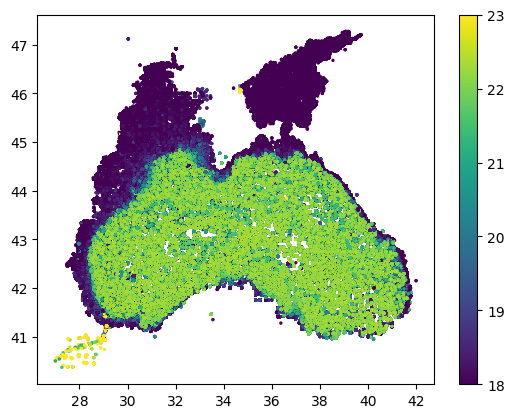

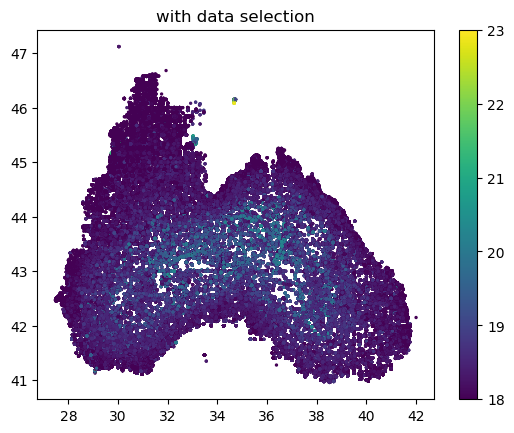

size(value) = (931515,)


PyObject Text(0.5,1,u'with data selection')

In [7]:
sel=(value.>16) .& (value.<23).& .~((lon.>34.75) .& (lat.>45.25)) .& 
.~((lon.<29.5) .& (lat.<41.125)) .& (depth.<55) .& (timeval .> DateTime(Date(1950)))

scatter(lon,lat,s=2,c=value,vmin=18,vmax=23);colorbar()

@show(size(value))

value=value[sel]
lon=lon[sel]
lat=lat[sel]
depth=depth[sel]
timeval=timeval[sel]
ids=ids[sel]

@show(size(value))
figure()

scatter(lon,lat,s=2,c=value,vmin=18,vmax=23);colorbar()
title("with data selection")

In [8]:
timeval[1]

1951-07-18T22:00:00

Observational error variance inflation factor

In [9]:
rdiag=1.0./divand.weight_RtimesOne((lon,lat,depth),(0.03,0.03,10));
mean(rdiag)

183.60798908927507

Useful functions to define new coordinates

In [10]:
function dayinyear(x); return Dates.value(Date(x)-Date(Dates.year(x))); end

function daysince1900(x); return Dates.value(Date(x)-Date(Dates.year(DateTime(1900)))); end

daysince1900 (generic function with 1 method)

Prepare a new analysis space: depth, day-in-a-year, time-in-days-from-1900

In [11]:
coordinatesfordetrending=(depth,dayinyear.(timeval),daysince1900.(timeval));
tmin,tmax=extrema(daysince1900.(timeval))
maskt,(pmt,pnt,pot),(xit,yit,zit) = divand.divand_rectdom(depthr,0:10:365,tmin:150:tmax);

Two user functions defining the two scales. One is the trend analysis, the other the normal analysis.

In [12]:
function H1K1(data)
    K1d,s=divand.divandrun(maskt,(pmt,pnt,pot),(xit,yit,zit),coordinatesfordetrending,data,(20,100,9000),1*rdiag;moddim=[0,365,0]);
    #K1d,s=divandrun(mask[1],pm[1],xi[1],x,data,len[1],epsilon2)    
    return K1d,data-divand_residual(s,K1d)
end
function H2K2(data)
    K2d,s=divand.divandrun(mask,(pm,pn,po),(xi,yi,zi),(lon,lat,depth),data,(1.5,1.,10),1*rdiag);
    #K1d,s=divandrun(mask[1],pm[1],xi[1],x,data,len[1],epsilon2)    
    return K2d,data-divand_residual(s,K2d)
end


H2K2 (generic function with 1 method)

Simple analysis for the trend space

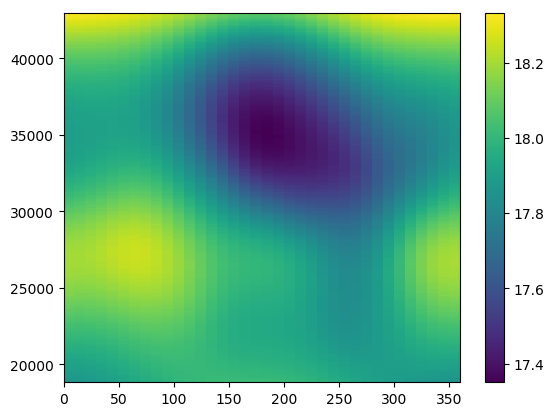

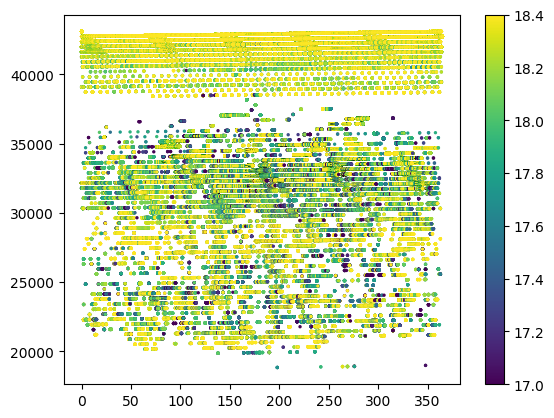

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000381BA2E8>

In [13]:
fdet,bidon=H1K1(value-mean(value));

pcolor(yit[1,:,:],zit[1,:,:],mean(value)+fdet[1,:,:]),colorbar()
figure()
scatter(coordinatesfordetrending[2],coordinatesfordetrending[3],s=2,c=value,vmin=17,vmax=18.4);colorbar()

Simple surface analysis

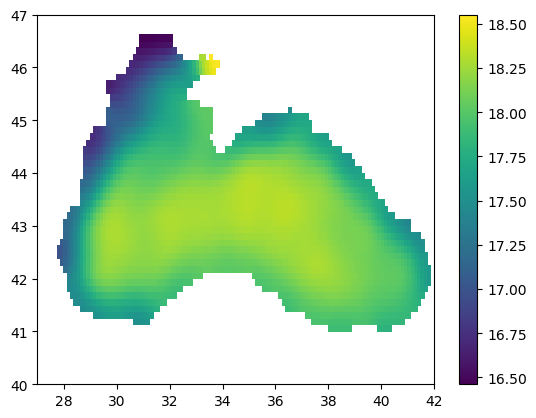

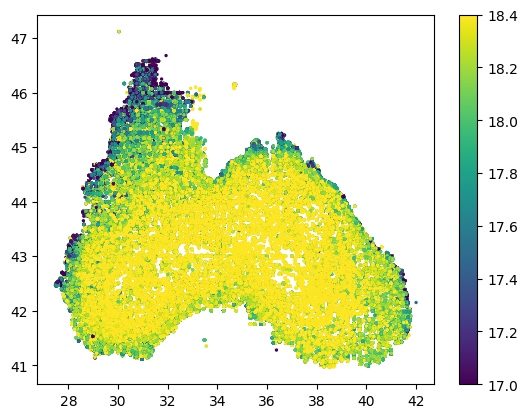

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000091B57278>

In [14]:
fsur,bidon=H2K2(value-mean(value))
fsurori=fsur;

figure()
pcolor(xi[:,:,1],yi[:,:,1],mean(value)+fsur[:,:,1]),colorbar()
figure()
scatter(lon,lat,s=2,c=value,vmin=17,vmax=18.4);colorbar()

## Now detrending via scale separation

In [15]:
?scaleseparation

search: scaleseparation



```
Phi1,H1Phi1,Phi2,H2Phi2=scaleseparation(K1andH1K1,K2andH2K2,d;niter=10)
```

# Input:

  * `K1andH1K1` : function, when called with a vector of data d, provides in return Kd,d-HK d ; i.e. the gridded analysis Kd an residual d-HKd for analysis tool 1
  * `K2andH2K2` : function, when called with a vector of data d, provides in return Kd,d-HK d ; i.e. the gridded analysis Kd an residual d-HKd for analysis tool 2
  * `d` : data array
  * `niter=` : optional keyword parameter defining the number of iterations used to invert I - H2K2 H1K2. Default is 10

# Output:

  * `Phi1` : analysis for tool 1 in which analysis of scale 2 is taken out
  * `H1Phi1`  : analysis at data locations for tool 1 in which analysis of scale 2 is taken out
  * `Phi2` : analysis for tool 2 in which analysis of scale 1 is taken out
  * `H2Phi2`  : analysis at data locations for tool 2 in which analysis of scale 1 is taken out

Tool to separate scales using two different analysis provided as two input functions

K1 should be related to the larger scales (or scales with high signal/noise ratios) and K2 to smaller or less energetic scales. If in doubt invert both and test with different number of iterations while looking at convergence.

see 	"Multi-scale optimal interpolation: application to DINEOF analysis spiced with a local optimal interpolation" 	http://hdl.handle.net/2268/165394

Here the two fields can have different supports (one could be a 3D analysis and the other one a season-depth analysis for example. Only the observational operators must provide the same data array at the output. In other words K1,HK1=K1andH1K1 should provide an output array HK1 of the same dimensions as the data array d and the output HK2 from K2,HK2=K2andH2K2


In [16]:
fdet,dd1,fsur,dd2=scaleseparation(H1K1,H2K2,value-mean(value);niter=10);

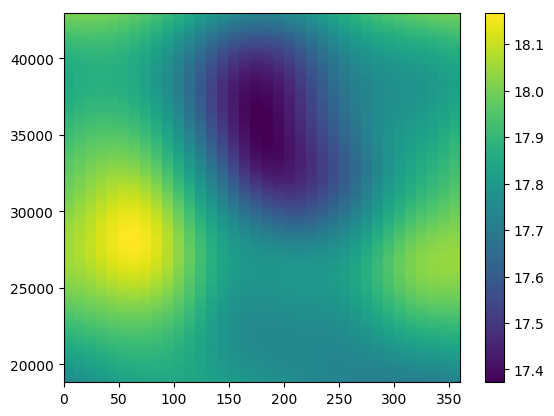

In [ ]:
figure
pcolor(yit[1,:,:],zit[1,:,:],mean(value)+fdet[1,:,:]),colorbar()
figure()
scatter(coordinatesfordetrending[2],coordinatesfordetrending[3],s=2,c=value,vmin=17,vmax=18.4);colorbar()

In [ ]:
figure()
pcolor(xi[:,:,1],yi[:,:,1],mean(value)+fsur[:,:,1]),colorbar()



In [ ]:
figure()
pcolor(xi[:,:,1],yi[:,:,1],fsurori[:,:,1]-fsur[:,:,1]),colorbar()
title("Direct analysis minus detrended analysis")

In [ ]:
plot((fdet[1,:,30]))